# Creating a simple neural network

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [2]:


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

60000


Text(0.5, 1.0, '5')

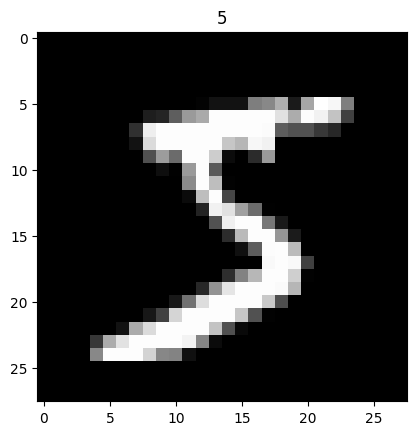

In [10]:
print(len(train_dataset))
plt.imshow(train_dataset[0][0].squeeze(), cmap="gray")
plt.title(str(train_dataset[0][1]))

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64

KeyboardInterrupt: 

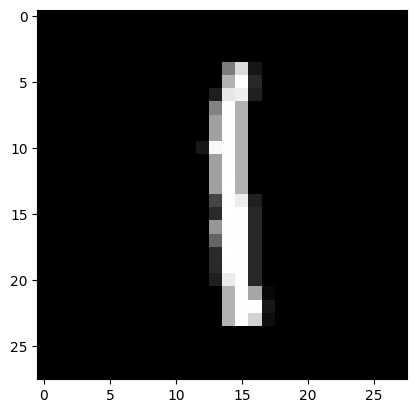

In [11]:
for x, y in train_loader:
    print(y.shape)
    idx= np.random.randint(1)
    plt.imshow(x[idx].squeeze(), cmap="gray")

In [12]:
class MonreseaudeNeurone(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input if needed (e.g., for MNIST 28x28 images)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



In [60]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


MonreseaudeNeurone(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [68]:

loss_function = nn.CrossEntropyLoss()



# Training loop
epochs = 5
iterations = {}
losses = {}

for lr in [1.0,0.1,0.01,0.001,0.0001]:
    print("=="*50)
    print(f"lr : {lr}")
    print("=="*50)
    model = MonreseaudeNeurone()
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    iteration_exp = []
    losse_exp = []
    count = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Reset gradients
            data= data.to(device)              # Put data on device
            target = target.to(device)
            output = model(data)                 # Forward pass
            loss = loss_function(output, target) # Compute loss
            loss.backward()                      # Compute gradients
            optimizer.step()                     # Update weights

            if batch_idx %100:
                iteration_exp.append(count)
                losse_exp.append(loss.item())
                count+=1

        print(f'Train Epoch: {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
    losses[lr] = losse_exp
    iterations[lr] = iteration_exp

Train Epoch: 1 [29984/60000] Loss: 2.353805
Train Epoch: 2 [29984/60000] Loss: 2.321721
Train Epoch: 3 [29984/60000] Loss: 2.427503
Train Epoch: 4 [29984/60000] Loss: 2.309363
Train Epoch: 5 [29984/60000] Loss: 2.238381


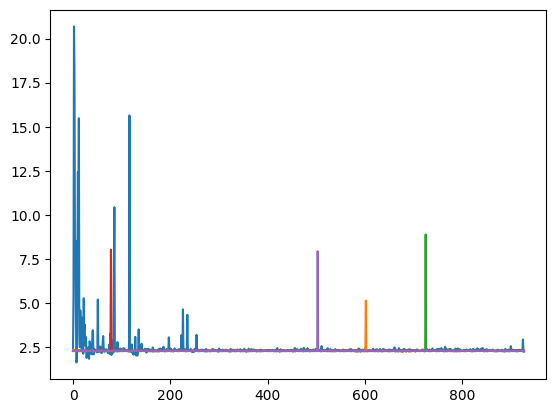

In [ ]:
for key, value in losses.items():

    plt.plot(iterations[key],value,label = "lr : " + str(key))
plt.legend()

In [67]:
for x,y in train_loader:
    ypredit = myfirstnn(x)
    ....

SyntaxError: invalid syntax (776407033.py, line 3)

In [27]:
60000/64


937.5